<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/nn-01-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Introduction to Neural Networks: Regression using TensorFlow 2

# Hands-On

1. Choose your level of abstraction and work through the notebook
  * you can leave out all deep dives and will still be able to follow
  * you can also directly make the experiments in the number 2
2. Train your own Keras model
  * go to <a href='#scrollTo=jZzGU633WNvt'>Part V</a> and execute all the cells before if you haven't yet
  * can you get better by making the network more complex?
  * how would you know? how is the loss and metric changing?
  * do you think the number of epochs is chosen wisely? adjust accordingly
3. Make experiments with network architecture
  * go to <a href='#scrollTo=w_Zspns8WpkH'>Part VI</a>
  * create another complex function and make sure the network can approximate it

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

# Part I: The use case and data

## We begin with a plot of a dependent variable

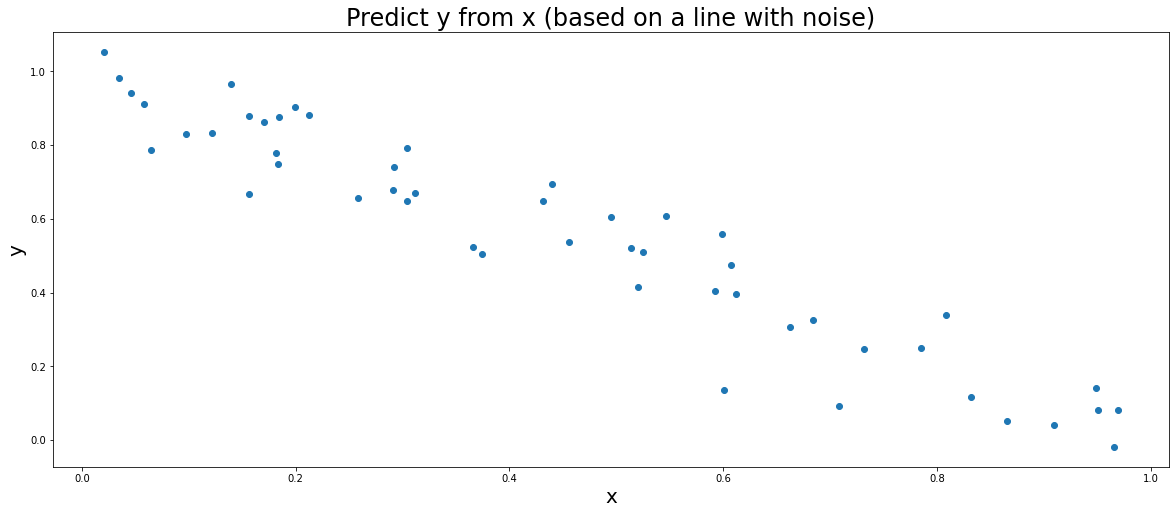

In [3]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(0, 1, n))
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

## Let's find a matching example

_Let's change the title and what is on the axis to match our application_

## _Challenge: How do we fit the best line possible?_

* Maybe to predict the future
* Or understand the nature of the data

_Having a **line** is our prior believe, we will later remove this assumption_ 

In [4]:
x, y

(array([0.02058449, 0.03438852, 0.04645041, 0.05808361, 0.06505159,
        0.09767211, 0.12203823, 0.13949386, 0.15599452, 0.15601864,
        0.17052412, 0.18182497, 0.18340451, 0.18485446, 0.19967378,
        0.21233911, 0.25877998, 0.29122914, 0.29214465, 0.30424224,
        0.30461377, 0.31171108, 0.36636184, 0.37454012, 0.43194502,
        0.44015249, 0.45606998, 0.49517691, 0.51423444, 0.52006802,
        0.52475643, 0.54671028, 0.59241457, 0.59865848, 0.60111501,
        0.60754485, 0.61185289, 0.66252228, 0.68423303, 0.70807258,
        0.73199394, 0.78517596, 0.80839735, 0.83244264, 0.86617615,
        0.9093204 , 0.94888554, 0.95071431, 0.96563203, 0.96990985]),
 array([ 1.05326216,  0.98274831,  0.94198476,  0.91180602,  0.78709621,
         0.83034347,  0.83189789,  0.96621836,  0.87836731,  0.66767734,
         0.86188427,  0.7796668 ,  0.74890329,  0.87631317,  0.90342617,
         0.8807889 ,  0.65729827,  0.67784962,  0.74098169,  0.79331227,
         0.64746881,  0.66

# Part II: Building a model (structure, architecture)

## Our model: linear

### ```y = m*x + b```

* `m` is the slope 
* `b` is the y-intercept


In [5]:
class LinearModel:
  
  def __init__(self, m=0, b=0):
    self.m = m
    self.b = b
    
  def __call__(self, x):
    y = self.m * x + self.b
    return y

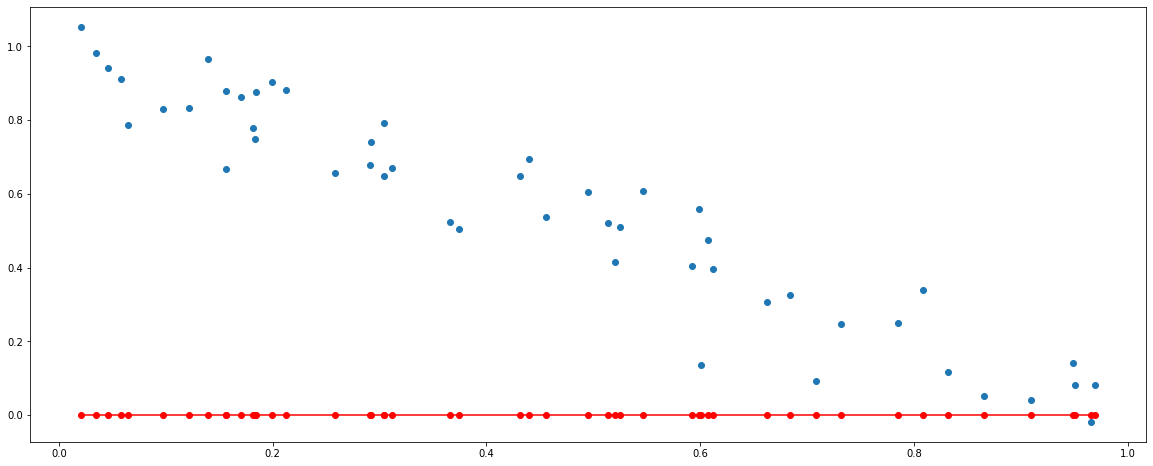

In [6]:
model = LinearModel()
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## How wrong are we?
### This is obviously wrong, but how wrong are we?

In [7]:
def error(y_true, y_pred):
  return np.sum(y_true - y_pred)
error(y, y_pred)

27.689078353052434

In [8]:
def absolute_error(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred))
absolute_error(y, y_pred)

27.72629445995496

In [9]:
def mean_absolute_error(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / len(y_true)
mean_absolute_error(y, y_pred)

0.5545258891990992

### The loss/error depends on our model and its parameters

<img src='https://djcordhose.github.io/ml-workshop/img/loss.png'>

# Part III: Naive Training, bringing down the loss in a loop 

Parameters to tweak
* m for the slope
* b for the y-intercept

naive implementation

1. if we bring m or b up or down, does this improve the loss?
1. if so, do it
1. rinse and repeat for a number of times

In [10]:
model = LinearModel()

EPOCHS = 500
learning_rate = 0.01

losses = []

for step in range(EPOCHS):
  y_pred = model(x)
  
  loss = mean_absolute_error(y, y_pred)
    
  # just for logging
  losses.append(loss)
  
  # let's try m
  new_model = LinearModel(m = model.m + learning_rate, b = model.b)
  new_y_pred = new_model(x)
  new_loss = mean_absolute_error(y, new_y_pred)
  
  if new_loss < loss:
    model.m += learning_rate
  else:
    model.m -= learning_rate
    
  # then b
  new_model = LinearModel(m = model.m, b = model.b + learning_rate)
  new_y_pred = new_model(x)
  new_loss = mean_absolute_error(y, new_y_pred)
  
  if new_loss < loss:
    model.b += learning_rate
  else:
    model.b -= learning_rate


"slope (m): {}, y-intercept (b): {}".format(model.m, model.b)    

'slope (m): -0.9400000000000006, y-intercept (b): 0.9600000000000006'

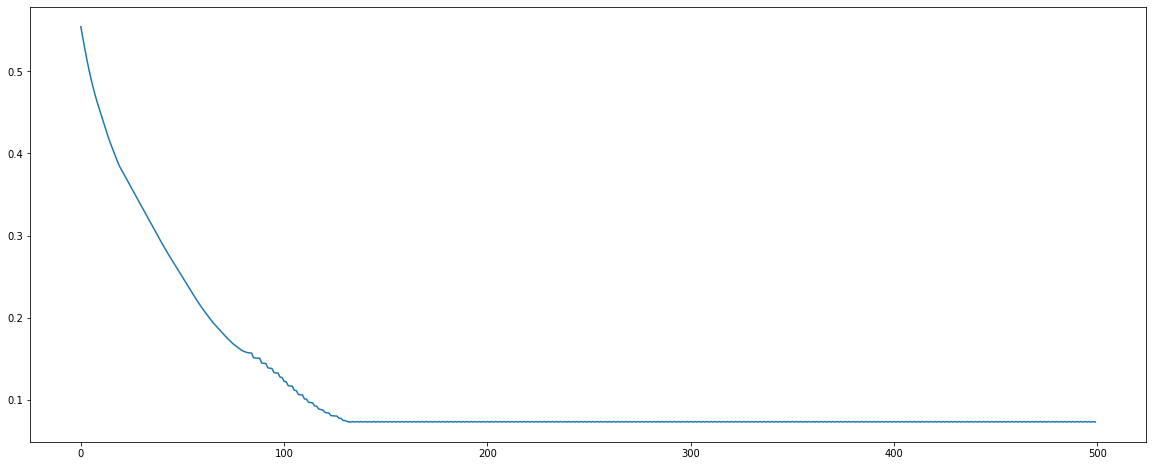

In [11]:
# plt.yscale('log')
plt.plot(losses);

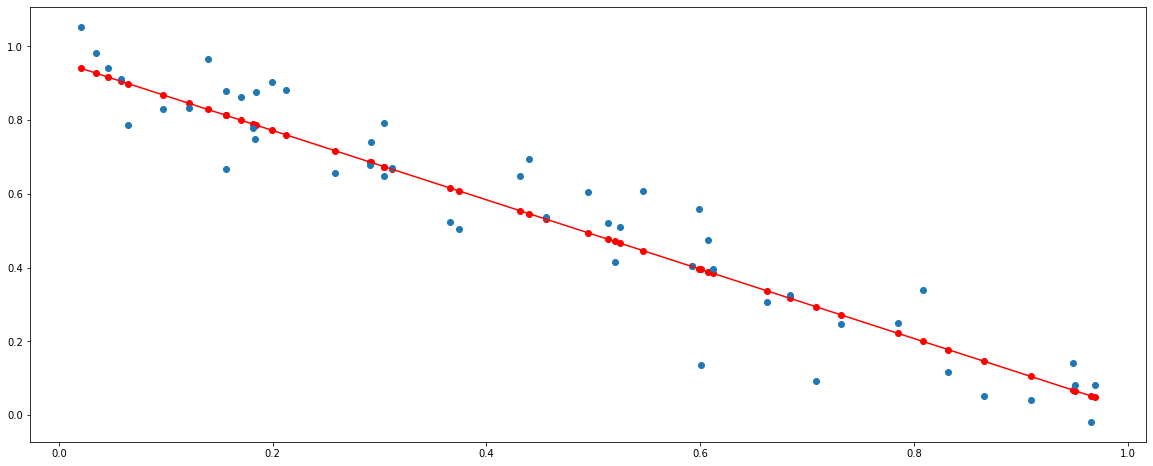

In [12]:
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## We already have a working solution: But does this scale to an example with many more parameters and more inputs?

1. Calculating the output might be expensive
2. Trying out all parameters in a random way like we do would have a bad performance for a large problem
3. Wouldn't we also need to try them in combination?

# Part IV: Change our solution to become a state of the art neural network using TensorFlow

1. Replace our model with a fully connected layer
2. Use a standard loss function
3. Finding parameters to tune in a more efficient way
4. Changing parameters in a more subtle way

In [13]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.3.0'

In [14]:
tf.random.set_seed(42)

In [15]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Step 1: use a dense layer instead of our simple model
* Scales well for as many neurons and inputs as we want
* Remember: for now we are assuming a line, but this is a prior that might not be necessary
* Efficient implementation on GPUs



### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### This can be expressed using a matrix multiplication

In [16]:
%%time 

# parameters of the neuron (can be learned), defining the function to apply
w = tf.constant([[1.5], [-2], [1]], dtype='float32')
b = tf.constant([6], dtype='float32')

# variable input being fed through the parameterized neuron
example_x = tf.constant([[10, 6, 8]], dtype='float32')

# computed output
example_y = tf.matmul(example_x, w) + b
print(example_y.numpy()[0][0])

17.0
CPU times: user 17.5 ms, sys: 12.8 ms, total: 30.3 ms
Wall time: 31.5 ms


In [17]:
from tensorflow.keras.layers import Layer

# we derive from a TensorFlow Layer
class LinearLayer(Layer):
  """y = w.x + b"""

  # initializing our layer
  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      # these are our weights, which can be learned, initialized normally around 0 with stddev of 2
      self.w = tf.Variable(
          initial_value = tf.random_normal_initializer(stddev=2)(shape=(input_dim, units), dtype='float32'),
          trainable=True,
          name='weights')
      # these are our bisases, also can be learned, initialized as 0
      self.b = tf.Variable(
          initial_value = tf.zeros_initializer()(shape=(units,), dtype='float32'),
          trainable=True,
          name='biases')

  # what the layer does (some as in our example before)
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
# just one neuron and one input (but could be as many as we like)    
linear_layer = LinearLayer()
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[0.654937]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Same prediction as before, but now using scalable matrix multiplcation

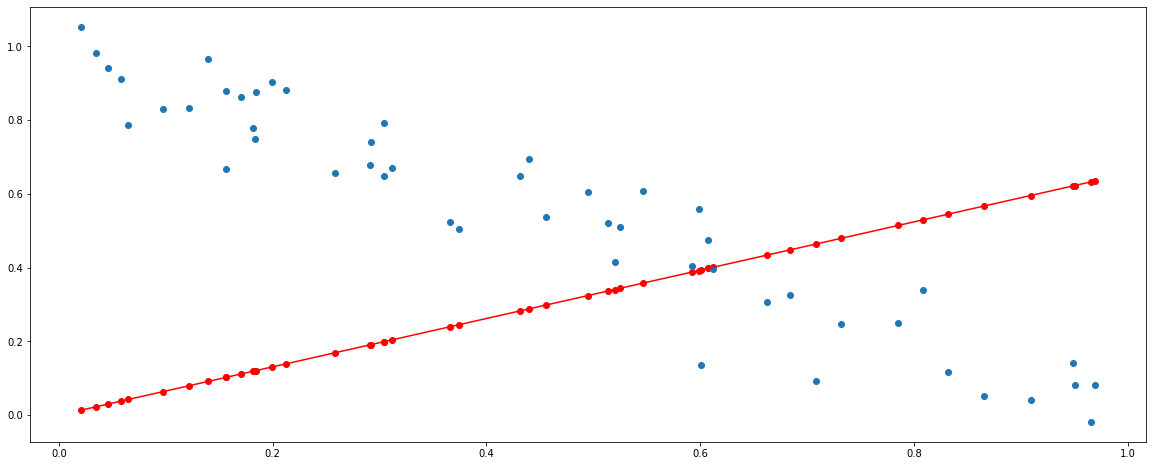

In [18]:
x_tensor = tf.reshape(tf.constant(x, dtype=tf.float32), (n, 1))
y_tensor = tf.reshape(tf.constant(y, dtype=tf.float32), (n, 1))

y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

### you can see slope and offset are just not right, because they have been initialized randomly


In [19]:
"slope (m): {}, y-intercept (b): {}".format(linear_layer.w.numpy()[0], linear_layer.b.numpy()[0])    

'slope (m): [0.654937], y-intercept (b): 0.0'

## Step 2: use standard loss and metric
* what we defined is called mean absolute error: mae
* mean squared error is more common, it squares the differences and gives high values a larger weight: mse
* both are pre-defined efficiently in TensorFlow 2

### Mean Absolute Error

what we had before implemented more efficiently

In [20]:
tf.losses.mean_absolute_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred)).numpy()

0.47336397

### Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [21]:
def mean_squared_error(y_true, y_pred):
  return np.sum(np.square(y_true - y_pred)) / len(y_true)
mean_squared_error(y, y_pred)

9.539652099609375

In [22]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred)).numpy()

0.29605633

### R2 Metric: MSE and MAE are not speaking

* Loss functions need to be differentiable (you will see later why)
* This often restricts how speaking they are in terms of business value
* Metrics do not have that resriction, but take the same parameters
* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/r2.png?raw=1'>
<small>
CC BY-SA 3.0, https://commons.wikimedia.org/wiki/File:Coefficient_of_Determination.svg
</small>

https://en.wikipedia.org/wiki/Coefficient_of_determination


In [23]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [24]:
r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()

-2.3947566

## Step 3: Finding parameters to tune

### Backpropagation algorithm: The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### Loss depends on the trainable variables, in our case two parameters: weight and bias

This is how the loss function might change depending on those variables

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

### Looking at the loss surface for our problem

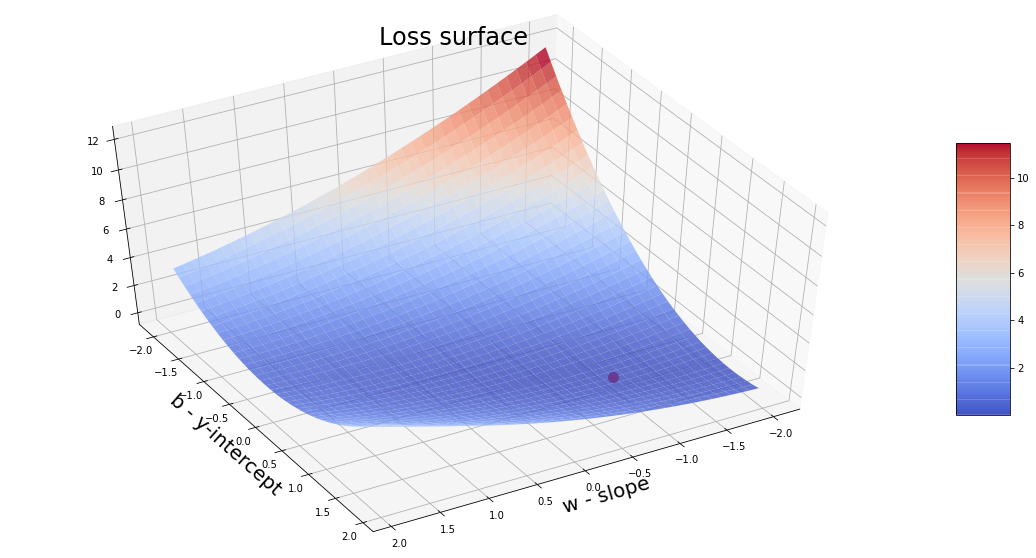

In [25]:
step = 0.1
w_space = np.arange(-2, 2, step)
b_space = np.arange(-2, 2, step)

sample_size = len(w_space)
losses = np.zeros((sample_size, sample_size))

linear_layer = LinearLayer()
min_loss = float('inf')
min_params = None

for wi in range(sample_size):
  for bi in range(sample_size):
      linear_layer.w.assign(w_space[wi].reshape(1, 1))
      linear_layer.b.assign(b_space[bi].reshape(1, ))

      y_pred = linear_layer(x_tensor)
      loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()
      if loss < min_loss:
        min_loss = loss
        min_params = (w_space[wi], b_space[bi])
      # the order seems weird, but aparently this is what the 3d plot expects  
      losses[bi, wi] = loss

# min_loss, min_params

# https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=figsize_3d)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Loss surface')

W, B = np.meshgrid(w_space, b_space)

# ax.plot_wireframe(W, B, losses)
surf = ax.plot_surface(W, B, losses, cmap=cm.coolwarm, 
                      #  linewidth=0, 
                       alpha=0.8,
                      #  antialiased=False
                       )
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('w - slope')
ax.set_ylabel('b - y-intercept')

ax.scatter(min_params[0], min_params[1], min_loss, s=100, color='r')

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-60); # default
ax.view_init(elev=50, azim=60);

### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [26]:
from tensorflow import GradientTape 
# GradientTape?

In [27]:
def tape_sample():
  x = tf.Variable(3.0)
  with tf.GradientTape() as tape:
    y = x * x
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

x: 3.0, y:9.0
dy/dx: 6.0


### Optional Deep Dive: Gradients 

#### Hands-On: create your own example

* Run all cells up to this point (Runtime->Run Before)
* first understand the example above: do the values make sense to you?
* change the value for x
* create your own function from x to y
* add another variable y depdends on
* if you want to use typical math functions (like sin or cos), you need to use `tf` as prefix

#### TensorFlow automatic differentiation can handle all kinds of differential functions

_when you use mathematic functions, you need to use the tensorflow version_


In [28]:
import math

def tape_sample():
  x = tf.Variable(math.pi)
  with tf.GradientTape() as tape:
#     y = math.sin(x)
    y = tf.sin(x) # when you use mathematic functions, you need to use the tensorflow version
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

x: 3.1415927410125732, y:-8.742277657347586e-08
dy/dx: -1.0


#### Losses must not rely on anything that is not differentiable or gives mostly zero or infinite gradients

http://math.mit.edu/classes/18.013A/HTML/chapter06/section03.html

In [29]:
def tape_sample():
  x = tf.Variable(0.0)
  with tf.GradientTape() as tape:
    y = 1 / x
#     y = 1 / x * x
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

x: 0.0, y:inf
dy/dx: -inf


## Step 4: Intermediate solution: applying all this to our training loop

In [30]:
linear_layer = LinearLayer()

EPOCHS = 1500
learning_rate = 0.01

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # get gradients of weights wrt the loss
  (dw, db) = tape.gradient(loss, linear_layer.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  linear_layer.w.assign_sub(learning_rate * dw)
  linear_layer.b.assign_sub(learning_rate * db)

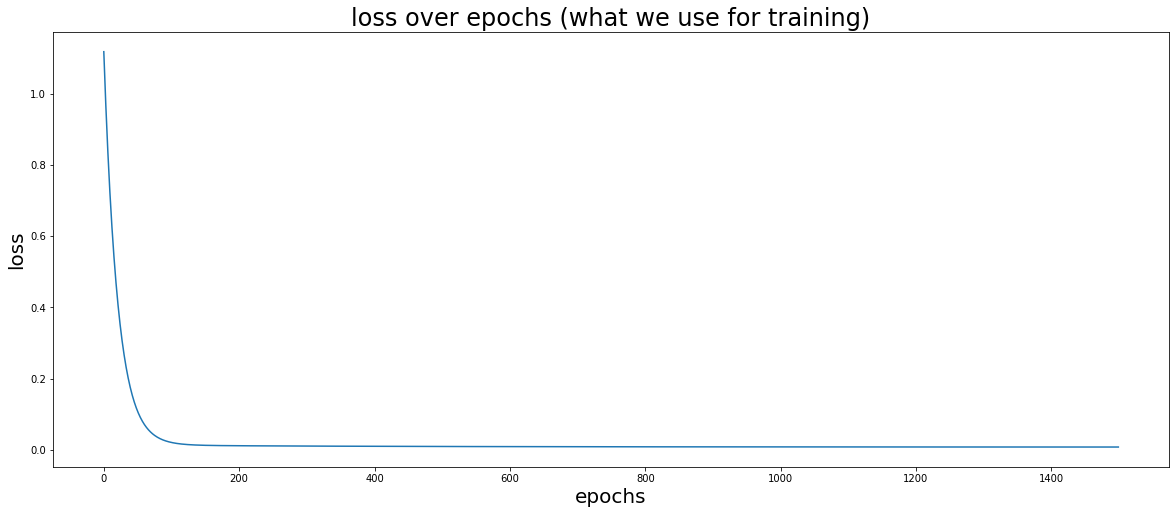

In [31]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

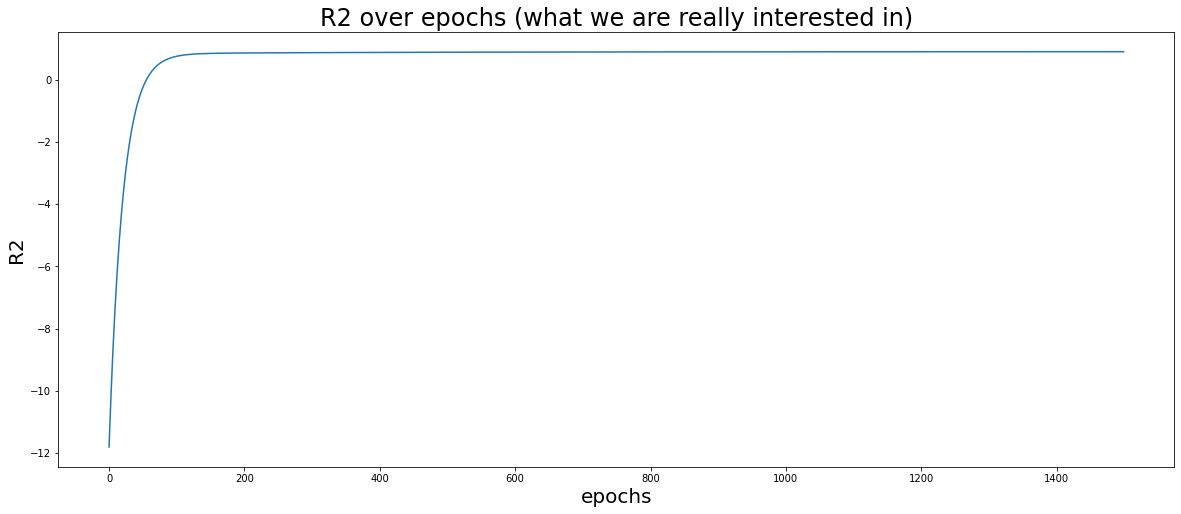

In [32]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2 over epochs (what we are really interested in)')

plt.plot(r2s);

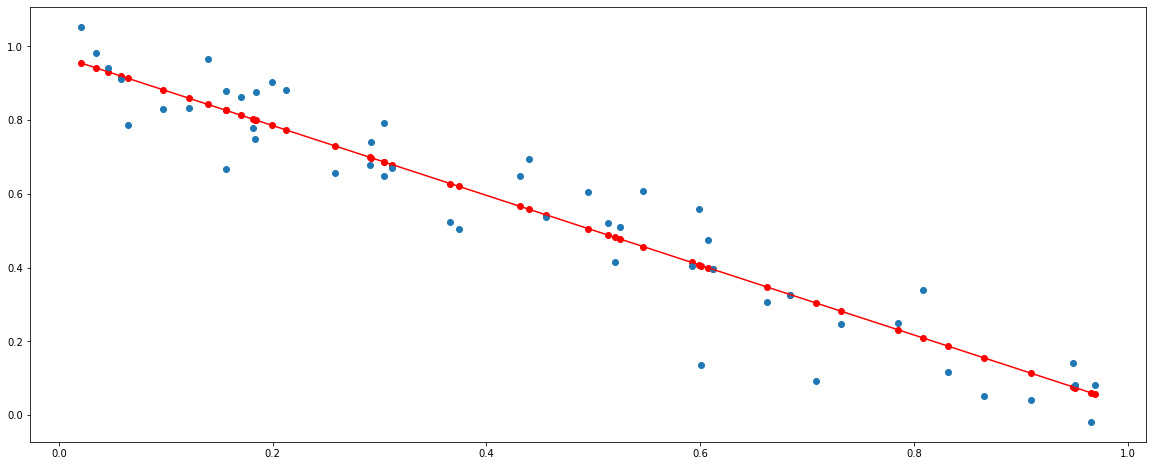

In [33]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## Step 5: Changing parameters

### Optional Deep Dive: Optimizers

* http://cs231n.github.io/optimization-1/
* http://cs231n.github.io/neural-networks-3/#update
* How they sound: http://blog.christianperone.com/2019/08/listening-to-the-neural-network-gradient-norms-during-training/

#### SGD: (Stochastic) Gradient Descent

_w = w - learning_rate * g_

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD?version=nightly

_Note: to make this stochastic it would require us to split our training data into batches and shuffle after each epoch_

#### Great visualizations on the performance of different optimizers

* using two very nasty error spaces: https://github.com/jettify/pytorch-optimizer/blob/master/README.rst#visualizations 

* SGD typically does its job, but often enough it does not: https://github.com/jettify/pytorch-optimizer/blob/master/README.rst#sgd-pytorch-built-in

* default optimizer is Adam, which is more powerful and autotunes: https://github.com/jettify/pytorch-optimizer/blob/master/README.rst#adam-pytorch-built-in

### Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)



In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [35]:
EPOCHS = 1500

losses = []
r2s = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

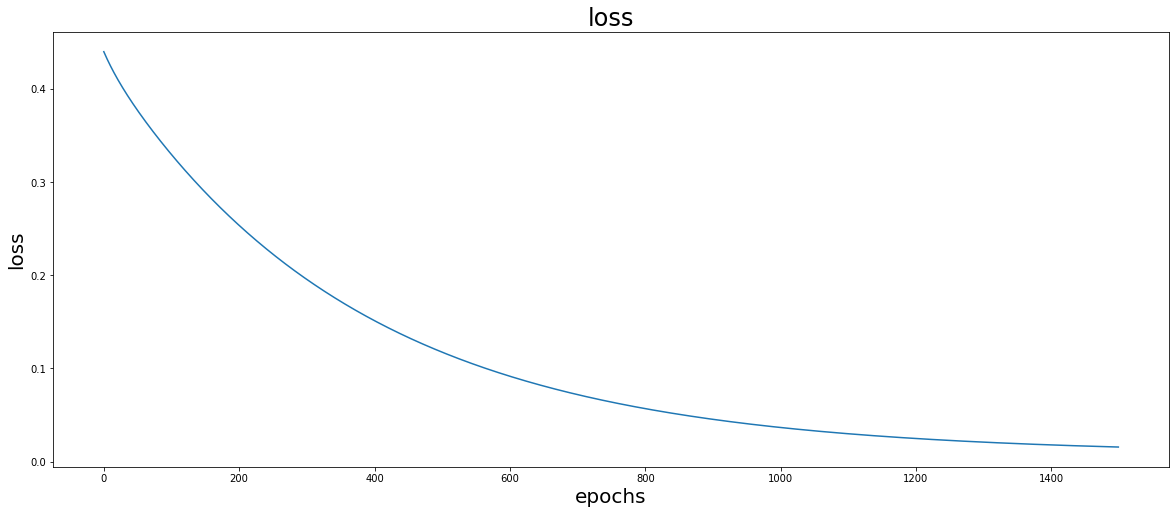

In [36]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('loss')

plt.plot(losses);

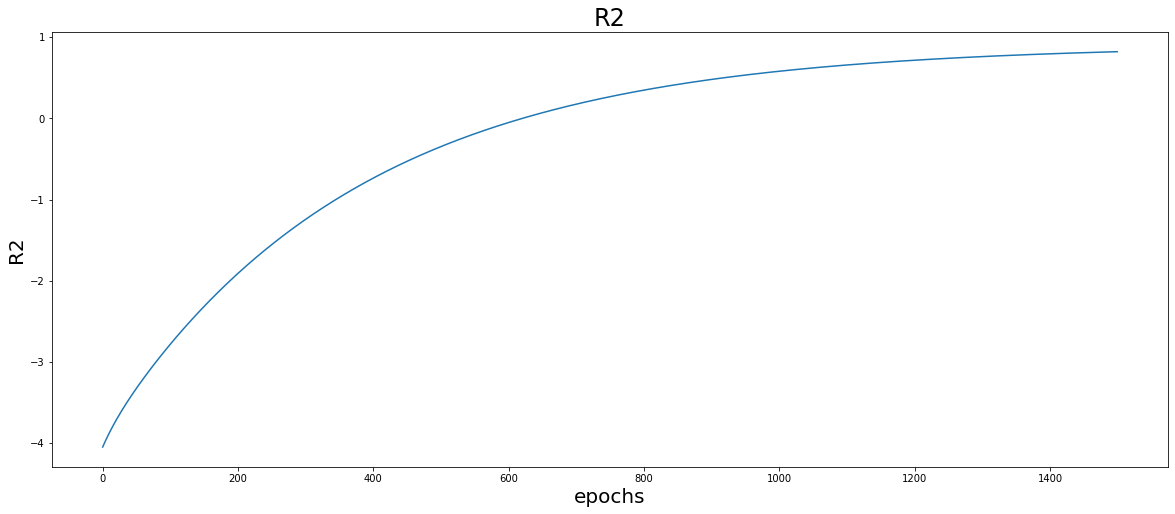

In [37]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2')

plt.plot(r2s);

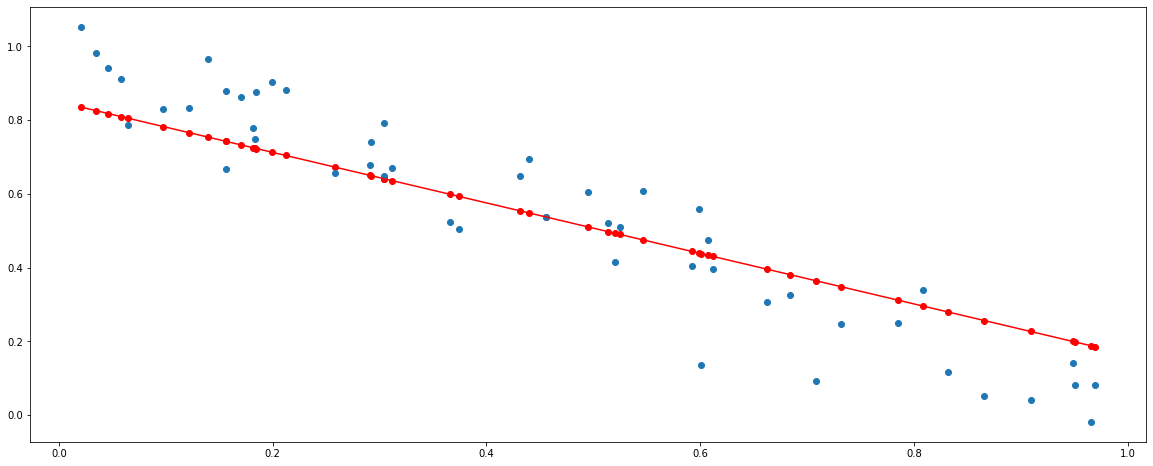

In [38]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

# Part V: The same solution using high level Keas API

## Keras vs TensorFlow

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/keras-vs-tensorflow.jpg?raw=1'>

https://twitter.com/fchollet at http://scaledml.org/2020/

In [39]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Defining a dense layer with a random number of neurons and inputs

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/neuron-to-layer.png?raw=1'>

With a little more work this would be a complete implementation of a fully connected layer



In [40]:
%%time 

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

CPU times: user 2.55 s, sys: 173 ms, total: 2.73 s
Wall time: 2.25 s


In [41]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.00981919839978218, 0.594458281993866)

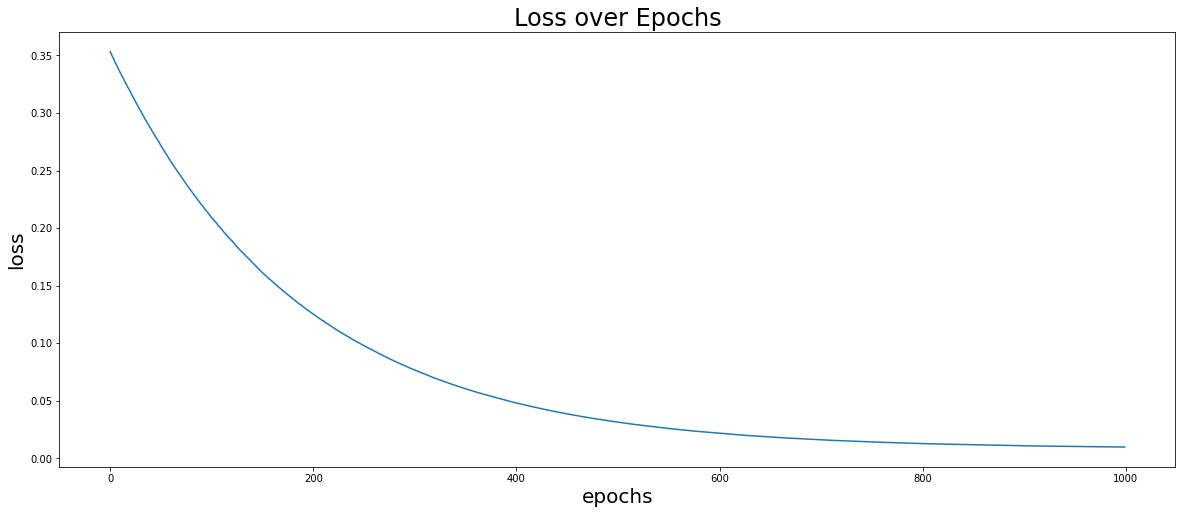

In [42]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

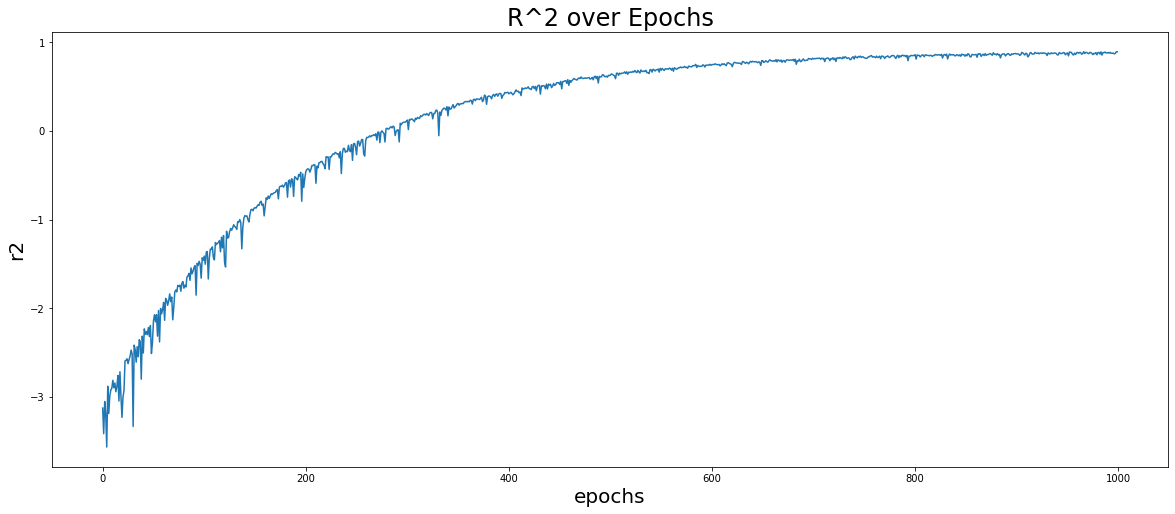

In [43]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

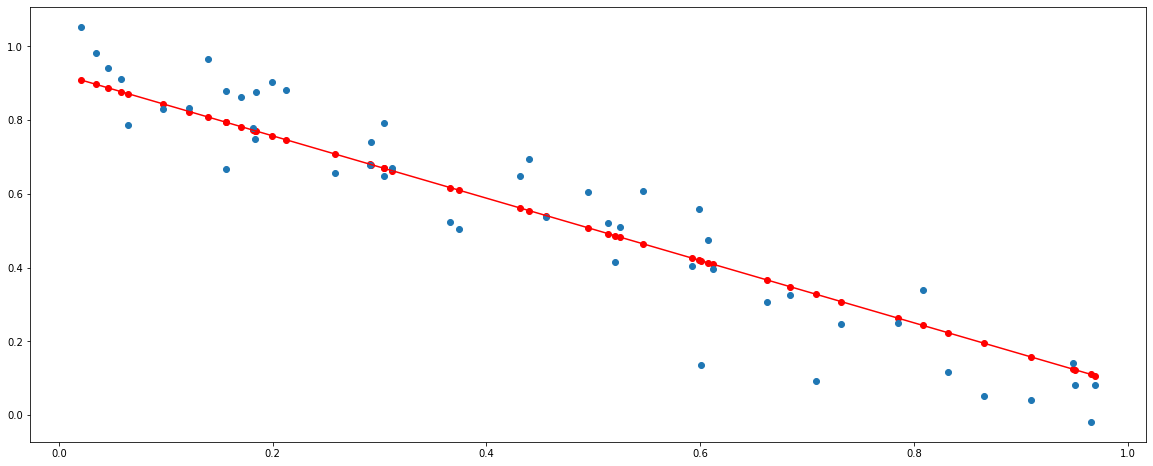

In [44]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

# Part VI: Neural Networks with 2-3 Layers can learn to approximate any function
* no additional prior required
* theoretically only one layer is enough, but this will not always train

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/nn-from-layer-to-model.png?raw=1'>

In [45]:
%%time 
 
model = tf.keras.Sequential([
  Dense(units=100, activation='relu', input_dim=1),                   
  Dense(units=100, activation='relu'),
  Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='linear')                   
])
model.summary()

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.Adam(), # Adam is a bit more powerful, but this could also be SGD
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4.57 s, sys: 385 ms, total: 4.95 s
Wall time: 3.62 s


In [46]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.007450217381119728, 0.6912959218025208)

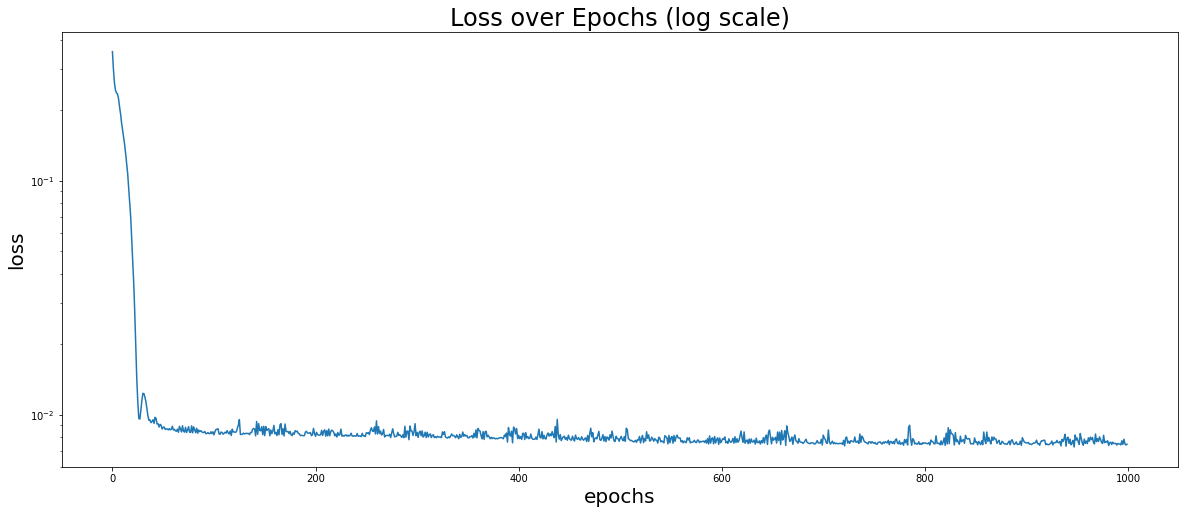

In [47]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

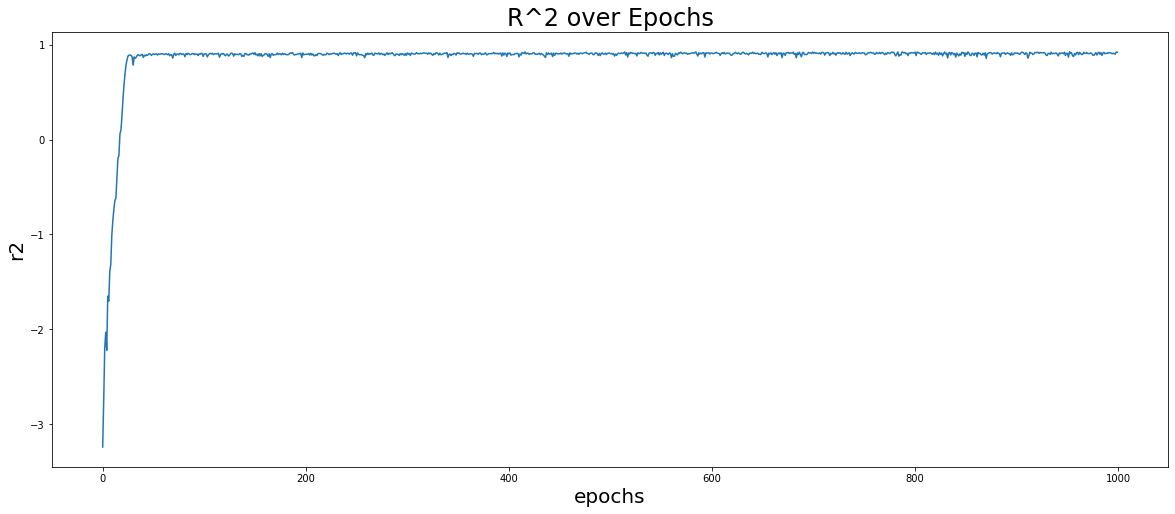

In [48]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

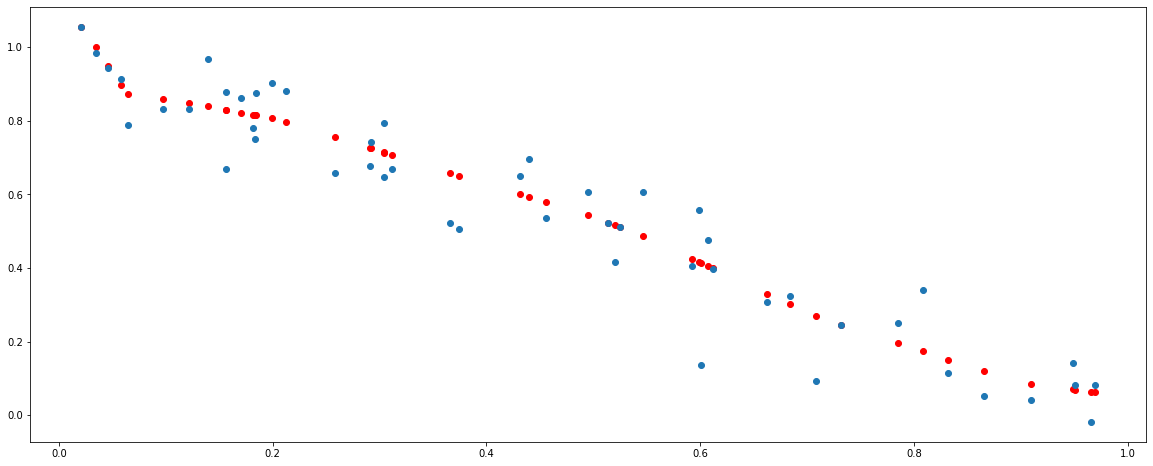

In [49]:
y_pred = model.predict(x)
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

# Deep Dive Part VII: Solving linear regression using OLS

## Ordinary least squares

_in our case this boils down to the simple form_

$w_1 = \frac{\sigma_{x,y}}{\sigma_{x}^{2}}$

$b = \bar{y} - w_1\bar{x}$

where 


$\text{covariance: } \sigma_{xy} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})$

$\text{variance: } \sigma^{2}_{x} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2$

https://en.wikipedia.org/wiki/Ordinary_least_squares
<br>
https://en.wikipedia.org/wiki/Ordinary_least_squares#Simple_linear_regression_model
<br>
https://en.wikipedia.org/wiki/Simple_linear_regression

In [50]:
cov_xy = np.cov(np.vstack((x, y)), ddof=0)[0, 1]
var_x = np.var(x, ddof=0)

w1 = cov_xy / var_x
b = np.mean(y) - w1*np.mean(x)

print('slope: %.2f' % w1)
print('y-intercept: %.2f' % b)

slope: -0.98
y-intercept: 0.99


In [51]:
# more general and powerful
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
# https://en.wikipedia.org/wiki/Polynomial_regression
# solution using closed form linear algebra

w1, b = np.polyfit(x, y, deg=1)
print('slope: %.2f' % w1)
print('y-intercept: %.2f' % b)

slope: -0.98
y-intercept: 0.99
